In [21]:
# Start a neo4j server 
# https://neo4j.com/docs/operations-manual/current/docker/introduction/
#!docker run --restart always --publish=7474:7474 --publish=7687:7687 --env NEO4J_AUTH=neo4j/admin1234 neo4j:5.19.0

In [22]:
# Install dependancies
#%pip install --upgrade --quiet langchain langchain-community langchain-openai langchain-experimental neo4j wikipedia tiktoken yfiles_jupyter_graphs py2neo 

In [23]:
import os
from langchain_core.runnables import (
    RunnableBranch,
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Tuple
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_experimental.graph_transformers import LLMGraphTransformer
from neo4j import GraphDatabase
from langchain_community.graphs import Neo4jGraph
from py2neo import Graph
from yfiles_jupyter_graphs import GraphWidget
from langchain_community.vectorstores import Neo4jVector
from langchain_community.vectorstores.neo4j_vector import remove_lucene_chars
from langchain.docstore.document import Document
import matplotlib.pyplot as plt
import networkx as nx

In [24]:
# Setting environment variables
os.environ["NEO4J_URI"] = "bolt://localhost:7687" #http://localhost:7474/browser/
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "admin1234"

# Initialize OpenAI client
# Retrieve the OpenAI API key from environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")

In [25]:
# Neo4j graph connection
graph = Graph(
    os.environ["NEO4J_URI"],
    auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
)

In [26]:
# Add graph documents to Neo4j
neo4j_graph = Neo4jGraph()
neo4j_graph.add_graph_documents(graph_documents, baseEntityLabel=True, include_source=True)

# ValueError: Could not use APOC procedures. Please ensure the APOC plugin is installed in Neo4j and that 'apoc.meta.data()' is allowed in Neo4j configuration 
# https://stackoverflow.com/questions/42740355/how-to-install-apoc-for-neo4j
#sudo cp /var/lib/neo4j/labs/apoc-4.3.0.3-core.jar /var/lib/neo4j/plugins/
#sudo chown neo4j:neo4j /var/lib/neo4j/plugins/apoc-4.3.0.3-core.jar
#sudo systemctl restart neo4j

# ClientError: {code: Neo.ClientError.Procedure.ProcedureRegistrationFailed} {message: apoc.meta.data is unavailable because it is sandboxed and has dependencies outside of the sandbox. Sandboxing is controlled by the dbms.security.procedures.unrestricted setting. Only unrestrict procedures you can trust with access to database internals.}
# https://stackoverflow.com/questions/48773505/neo4j-install-apoc-and-graph-algorithms-neo-clienterror-procedure-procedureregis
# edit /var/lib/neo4j/conf/neo4j.conf
## dbms.security.procedures.unrestricted=algo.*,apoc.*

In [19]:
# UAV dataset
# Sample documents to convert to graph documents (UAVs and weapons relationships)
documents = [
    Document(page_content="The MQ-9 Reaper UAV can carry up to 4 Hellfire missiles."),
    Document(page_content="The MQ-9 Reaper UAV can also carry up to 2 GBU-12 Paveway bombs."),
    Document(page_content="The RQ-4 Global Hawk UAV is used primarily for surveillance and carries no weapons."),
    Document(page_content="The MQ-1 Predator UAV can carry up to 2 Hellfire missiles."),
    Document(page_content="The X-47B UAV is a stealth aircraft and can carry up to 2 JDAM bombs."),
    Document(page_content="The MQ-20 Avenger UAV can carry up to 6 Hellfire missiles and 2 JDAM bombs."),
]

# Convert documents into graph documents
llm = ChatOpenAI(temperature=0, model_name="gpt-4-turbo")
llm_transformer = LLMGraphTransformer(llm=llm)
graph_documents = llm_transformer.convert_to_graph_documents(documents)

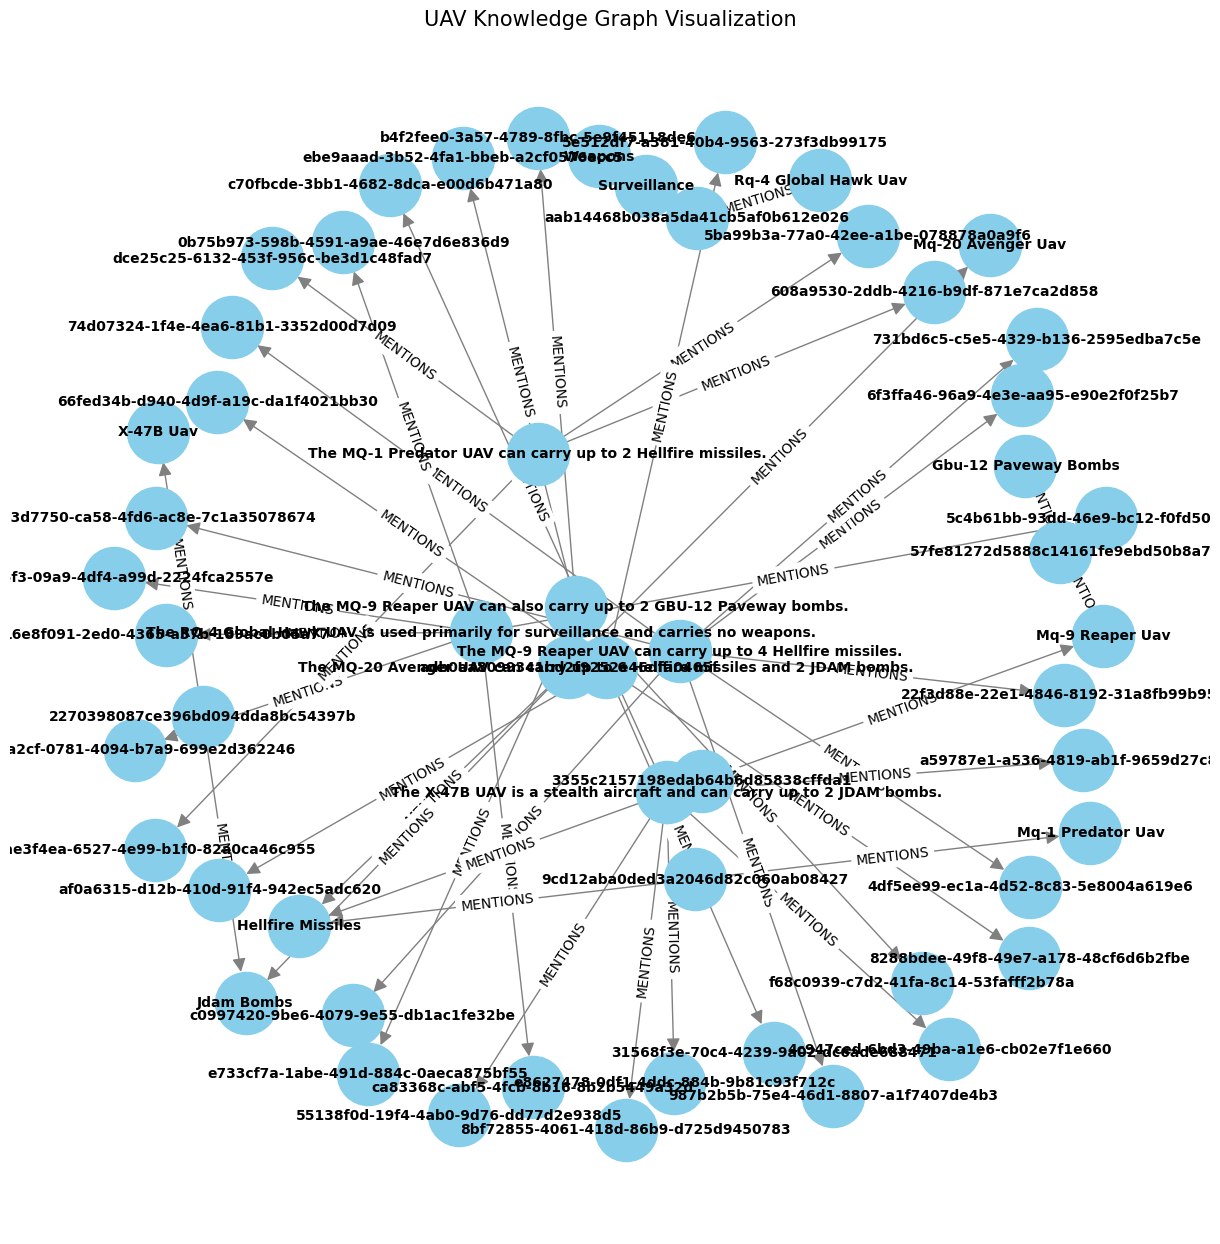

In [20]:
# Function to create and visualize a NetworkX graph
def visualize_graph(query: str):
    # Initialize an empty graph
    G = nx.DiGraph()

    # Run the query in Neo4j and collect results
    results = graph.run(query)
    for record in results:
        node_from = record["s"]["id"]
        node_to = record["t"]["id"]
        relationship = record["r"].__class__.__name__

        # Add nodes and edges to NetworkX graph
        G.add_node(node_from, label=record["s"].labels)
        G.add_node(node_to, label=record["t"].labels)
        G.add_edge(node_from, node_to, relationship=relationship)

    # Draw the graph
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=2000, font_size=10, font_weight='bold', arrowsize=20)
    edge_labels = nx.get_edge_attributes(G, 'relationship')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("UAV Knowledge Graph Visualization", fontsize=15)
    plt.show()

# Example Cypher query
query = "MATCH (s)-[r:MENTIONS]->(t) RETURN s, r, t LIMIT 50"
visualize_graph(query)

In [ ]:
vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

neo4j_graph.query("CREATE FULLTEXT INDEX entity IF NOT EXISTS FOR (e:__Entity__) ON EACH [e.id]")

class Entities(BaseModel):
    """Identifying information about entities."""
    names: List[str] = Field(
        ...,
        description="All the UAV, weapon, or organization entities that appear in the text"
    )

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are extracting UAV and weapon entities from the text."),
        ("human", "Use the given format to extract information from the following input: {question}")
    ]
)

entity_chain = prompt | llm.with_structured_output(Entities)

def generate_full_text_query(input: str) -> str:
    full_text_query = ""
    words = [el for el in remove_lucene_chars(input).split() if el]
    for word in words[:-1]:
        full_text_query += f" {word}~2 AND"
    full_text_query += f" {words[-1]}~2"
    return full_text_query.strip()

def structured_retriever(question: str) -> str:
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        response = neo4j_graph.query(
            """CALL db.index.fulltext.queryNodes('entity', $query, {limit:2})
            YIELD node, score
            CALL {
                WITH node
                MATCH (node)-[r:MENTIONS]->(neighbor)
                RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
                UNION ALL
                WITH node
                MATCH (node)<-[r:MENTIONS]-(neighbor)
                RETURN neighbor.id + ' - ' + type(r) + ' -> ' + node.id AS output
            }
            RETURN output LIMIT 50
            """,
            {"query": generate_full_text_query(entity)}
        )
        result += "\n".join([el['output'] for el in response])
    return result

def retriever(question: str):
    structured_data = structured_retriever(question)
    unstructured_data = [el.page_content for el in vector_index.similarity_search(question)]
    final_data = f"""Structured data:
{structured_data}
Unstructured data:
{"#Document ". join(unstructured_data)}
    """
    return final_data

In [ ]:
_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question,
in its original language.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

def _format_chat_history(chat_history: List[Tuple[str, str]]) -> List:
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer

_search_query = RunnableBranch(
    (
        RunnableLambda(lambda x: bool(x.get("chat_history"))).with_config(run_name="HasChatHistoryCheck"),
        RunnablePassthrough.assign(chat_history=lambda x: _format_chat_history(x["chat_history"]))
        | CONDENSE_QUESTION_PROMPT
        | ChatOpenAI(temperature=0)
        | StrOutputParser()
    ),
    RunnableLambda(lambda x: x["question"])
)

In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
Use natural language and be concise.
Answer:"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    RunnableParallel(
        {
            "context": _search_query | retriever,
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | llm
    | StrOutputParser()
)

In [27]:
# Initial question
chain.invoke({"question": "Which UAVs can carry Hellfire missiles?"})

'MQ-9 Reaper and MQ-1 Predator UAVs can carry Hellfire missiles.'

In [28]:
# Follow-up question
chain.invoke(
    {
        "question": "How many Hellfire missiles can it carry?",
        "chat_history": [("Which UAV can carry Hellfire missiles?", "The MQ-9 Reaper UAV can carry up to 4 Hellfire missiles.")]
    }
)

'The MQ-9 Reaper UAV can carry up to 4 Hellfire missiles.'

In [29]:
# Initial question
chain.invoke({"question": "Which UAV can carry the most ordinace,name the system, ordinance, and number ordinace the systam can carry?"})

'The MQ-20 Avenger UAV can carry up to 6 Hellfire missiles and 2 JDAM bombs, making it capable of carrying the most ordinance.'